# Parallel Optimisation

**Learning Objectives:**
- Understand which optimisers support parallelism
- Configure population-based optimisers for parallel execution
- Benchmark scaling performance
- Identify performance bottlenecks
- Apply best practices for thread-safe optimisation

**Prerequisites:** Optimisation Basics, ODE Fitting, basic understanding of parallelism

**Runtime:** ~10 minutes

## Introduction

Diffid supports **parallel evaluation** for population-based optimisers (CMA-ES, Dynamic Nested Sampling). However, the effectiveness depends on the evaluation cost and backend used.

### Key Insights

1. **DiffsolBuilder** with `.with_parallel(True)` uses Rust's rayon for parallel ODE integration
2. **Fast evaluations** (< 1ms) may see limited speedup due to efficient solver caching
3. **Python callables** cannot be parallelised with threads (GIL), but **multiprocessing** works

This tutorial covers:
- Parallel ODE fitting with `DiffsolBuilder`
- Using `multiprocessing` for expensive Python callables
- Understanding when parallelism helps

In [ ]:
import multiprocessing
import time

import diffid
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

# Detect available cores
n_cores = multiprocessing.cpu_count()
print(f"Available CPU cores: {n_cores}")

## Test Problem: Lotka-Volterra ODE Fitting

We'll use the predator-prey model from Tutorial 6. ODE integration is computationally expensive, making it ideal for demonstrating parallel speedup.

$$\frac{dx}{dt} = \alpha x - \beta xy \quad \text{(prey)}$$
$$\frac{dy}{dt} = \delta xy - \gamma y \quad \text{(predator)}$$

The DiffSL model definition and synthetic data generation:

In [2]:
# DiffSL model for Lotka-Volterra
model_str = """
in_i { alpha = 1.0, beta = 0.5, delta = 0.1, gamma = 0.5 }
x0 { 10.0 } y0 { 5.0 }
u_i {
    prey = x0,
    predator = y0,
}
F_i {
    alpha * prey - beta * prey * predator,
    delta * prey * predator - gamma * predator,
}
"""

# True parameters for data generation
true_params = {"alpha": 1.1, "beta": 0.4, "delta": 0.1, "gamma": 0.4}

# Generate synthetic data using scipy
# Longer time span = more expensive integration
np.random.seed(42)
t_data = np.linspace(0, 100, 500)  # Long integration with many points


def lotka_volterra(t, state, alpha, beta, delta, gamma):
    x, y = state
    return [alpha * x - beta * x * y, delta * x * y - gamma * y]


sol = solve_ivp(
    lotka_volterra,
    [t_data[0], t_data[-1]],
    [10.0, 5.0],
    args=(
        true_params["alpha"],
        true_params["beta"],
        true_params["delta"],
        true_params["gamma"],
    ),
    t_eval=t_data,
    method="RK45",
)

y_true = sol.y.T
y_observed = y_true + np.random.normal(0, 0.3, y_true.shape)

# Combine for DiffsolBuilder (time in first column)
data = np.column_stack((t_data, y_observed))

print(f"Data points: {len(t_data)}")
print("Time span: [0, 100]")
print("Parameters to fit: 4")
print(f"True parameters: {list(true_params.values())}")

Data points: 500
Time span: [0, 100]
Parameters to fit: 4
True parameters: [1.1, 0.4, 0.1, 0.4]


## Sequential vs Parallel: DiffsolBuilder

The key difference is the `.with_parallel()` method on `DiffsolBuilder`. When enabled, population-based optimisers evaluate multiple parameter sets concurrently.

Let's compare sequential and parallel CMA-ES on our ODE fitting problem:

In [ ]:
# Sequential execution (parallel=False)
print("Running CMA-ES (sequential)...")

start = time.time()

result_seq = (
    diffid.DiffsolBuilder()
    .with_diffsl(model_str)
    .with_data(data)
    .with_parameter("alpha", 0.8)
    .with_parameter("beta", 0.3)
    .with_parameter("delta", 0.05)
    .with_parameter("gamma", 0.3)
    .with_cost(diffid.SSE())
    .with_parallel(False)  # Sequential evaluation
    .with_optimiser(diffid.CMAES().with_max_iter(100).with_step_size(0.3))
    .build()
    .optimise()
)

time_seq = time.time() - start

print("\n" + "=" * 60)
print("CMA-ES (Sequential)")
print("=" * 60)
print(f"Solution:      {result_seq.x}")
print(f"True params:   {list(true_params.values())}")
print(f"Final SSE:     {result_seq.value:.3f}")
print(f"Evaluations:   {result_seq.evaluations}")
print(f"Time:          {time_seq:.2f}s")
print(f"Time per eval: {time_seq / result_seq.evaluations * 1000:.2f}ms")

## Parallel Execution

Now let's enable parallelism with `.with_parallel(True)`:

In [ ]:
# Parallel execution (parallel=True)
print("Running CMA-ES (parallel)...")

start = time.time()

result_par = (
    diffid.DiffsolBuilder()
    .with_diffsl(model_str)
    .with_data(data)
    .with_parameter("alpha", 0.8)
    .with_parameter("beta", 0.3)
    .with_parameter("delta", 0.05)
    .with_parameter("gamma", 0.3)
    .with_cost(diffid.SSE())
    .with_parallel(True)  # Parallel evaluation!
    .with_optimiser(diffid.CMAES().with_max_iter(100).with_step_size(0.3))
    .build()
    .optimise()
)

time_par = time.time() - start

print("\n" + "=" * 60)
print("CMA-ES (Parallel)")
print("=" * 60)
print(f"Solution:      {result_par.x}")
print(f"True params:   {list(true_params.values())}")
print(f"Final SSE:     {result_par.value:.3f}")
print(f"Evaluations:   {result_par.evaluations}")
print(f"Time:          {time_par:.2f}s")
print(f"Time per eval: {time_par / result_par.evaluations * 1000:.2f}ms")

speedup = time_seq / time_par
print(f"\n🚀 Speedup: {speedup:.2f}x (with {n_cores} cores)")

In [ ]:
# Parallel with larger population (more parallel work per generation)
print("Running CMA-ES (parallel, large population)...")

start = time.time()

result_par_large = (
    diffid.DiffsolBuilder()
    .with_diffsl(model_str)
    .with_data(data)
    .with_parameter("alpha", 0.8)
    .with_parameter("beta", 0.3)
    .with_parameter("delta", 0.05)
    .with_parameter("gamma", 0.3)
    .with_cost(diffid.SSE())
    .with_parallel(True)
    .with_optimiser(
        diffid.CMAES()
        .with_max_iter(50)
        .with_step_size(0.3)
        .with_population_size(2 * n_cores)  # Match population to available cores
    )
    .build()
    .optimise()
)

time_par_large = time.time() - start

print("\n" + "=" * 60)
print(f"CMA-ES (Parallel, Population={2 * n_cores})")
print("=" * 60)
print(f"Solution:      {result_par_large.x}")
print(f"True params:   {list(true_params.values())}")
print(f"Final SSE:     {result_par_large.value:.3f}")
print(f"Evaluations:   {result_par_large.evaluations}")
print(f"Time:          {time_par_large:.2f}s")
print(f"Time per eval: {time_par_large / result_par_large.evaluations * 1000:.2f}ms")

speedup_large = time_seq / time_par_large
print(f"\n🚀 Speedup: {speedup_large:.2f}x")

## Parallelising Python Callables with Multiprocessing

Python's GIL prevents thread-based parallelism for Python code. However, you can use **multiprocessing** to parallelise expensive Python functions by wrapping them appropriately.

Here's how to create a parallel-capable objective function:

In [ ]:
# Define an expensive objective function
def expensive_objective(params):
    """
    An expensive objective function that simulates computation.
    In practice, this could be a complex simulation, ML model, etc.
    """
    alpha, beta, delta, gamma = params

    # Simulate expensive computation (ODE integration with scipy)
    sol = solve_ivp(
        lotka_volterra,
        [0, 100],
        [10.0, 5.0],
        args=(alpha, beta, delta, gamma),
        t_eval=t_data,
        method="RK45",
    )

    if not sol.success:
        return 1e10  # Return large value for failed integrations

    # Compute SSE
    y_pred = sol.y.T
    return np.sum((y_pred - y_observed) ** 2)


# Test single evaluation time
n_evals = 20
test_params = [[0.8 + i * 0.02, 0.3, 0.05, 0.3] for i in range(n_evals)]

print(f"Testing {n_evals} sequential evaluations...")

start = time.time()
seq_results = [expensive_objective(p) for p in test_params]
time_seq_python = time.time() - start
print(
    f"Sequential: {time_seq_python:.2f}s ({time_seq_python / n_evals * 1000:.1f}ms/eval)"
)

# Note: Multiprocessing in notebooks has pickling limitations
# In a regular Python script, you would use:
print("""
💡 To parallelise in a script, use multiprocessing:

from concurrent.futures import ProcessPoolExecutor

def evaluate_batch_parallel(params_list, n_workers=8):
    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        return list(executor.map(expensive_objective, params_list))

# This provides near-linear speedup for expensive functions
""")

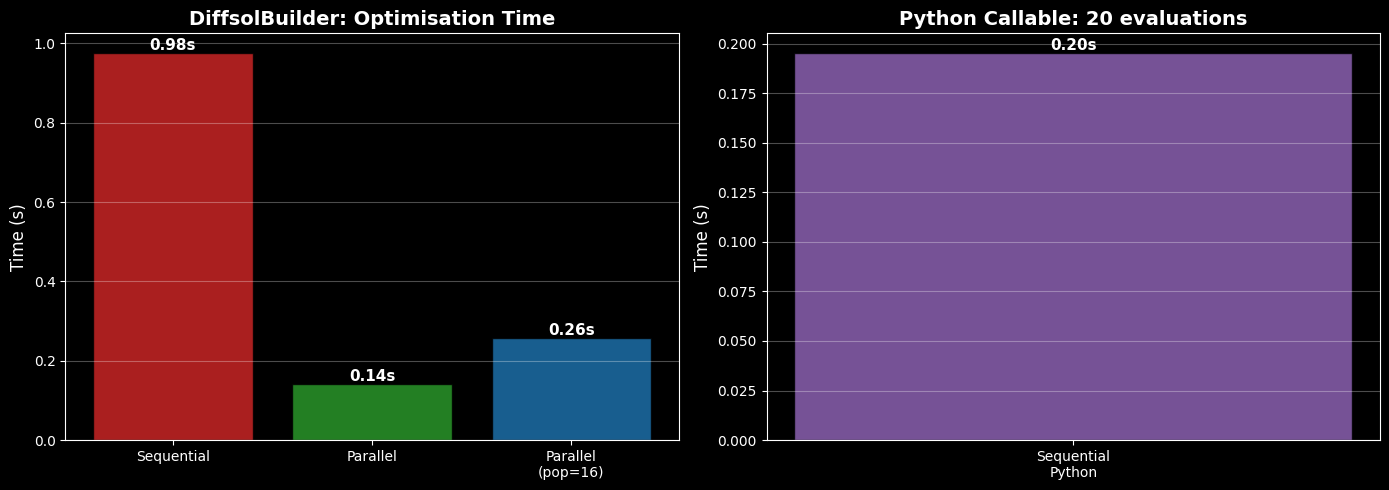


💡 Single Python evaluation: 9.8ms
   With multiprocessing, you could achieve near-linear speedup.


In [7]:
# Visualize DiffsolBuilder parallel performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Time comparison for DiffsolBuilder
methods = ["Sequential", "Parallel", f"Parallel\n(pop={2 * n_cores})"]
times = [time_seq, time_par, time_par_large]
colors = ["#d62728", "#2ca02c", "#1f77b4"]

bars = ax1.bar(methods, times, color=colors, alpha=0.8, edgecolor="black")
ax1.set_ylabel("Time (s)", fontsize=12)
ax1.set_title("DiffsolBuilder: Optimisation Time", fontsize=14, fontweight="bold")
ax1.grid(True, axis="y", alpha=0.3)

for bar, t in zip(bars, times, strict=False):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{t:.2f}s",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

# Single evaluation time for Python callable
ax2.bar(
    ["Sequential\nPython"],
    [time_seq_python],
    color="#9467bd",
    alpha=0.8,
    edgecolor="black",
)
ax2.set_ylabel("Time (s)", fontsize=12)
ax2.set_title(f"Python Callable: {n_evals} evaluations", fontsize=14, fontweight="bold")
ax2.grid(True, axis="y", alpha=0.3)
ax2.text(
    0,
    time_seq_python,
    f"{time_seq_python:.2f}s",
    ha="center",
    va="bottom",
    fontsize=11,
    fontweight="bold",
)

plt.tight_layout()
plt.show()

print(f"\n💡 Single Python evaluation: {time_seq_python / n_evals * 1000:.1f}ms")
print("   With multiprocessing, you could achieve near-linear speedup.")

## Understanding Parallel Performance

### Why DiffsolBuilder Speedups May Be Modest

DiffsolBuilder uses **solver caching** - each thread maintains cached ODE solver state that gets reused across evaluations. This makes sequential evaluation very fast, reducing the relative benefit of parallelism.

Parallelism helps more when:
- Evaluations are expensive (>10ms each)
- Large populations are used
- Cache reuse is limited (e.g., parameters vary widely)

### Multiprocessing vs Threading

| Approach | Use Case | Overhead |
|----------|----------|----------|
| `.with_parallel(True)` | DiffsolBuilder only | Low (shared memory) |
| `multiprocessing` | Any Python callable | Higher (process creation) |
| `threading` | I/O-bound tasks | GIL blocks CPU work |

For expensive Python simulations, multiprocessing provides the best parallelism.

In [ ]:
# Test DiffsolBuilder scaling with data size
data_sizes = [100, 200, 500]
scaling_results = []

print("Testing DiffsolBuilder scaling with data size...\n")

for n_points in data_sizes:
    # Generate data with different sizes
    t_test = np.linspace(0, 100, n_points)
    sol_test = solve_ivp(
        lotka_volterra,
        [t_test[0], t_test[-1]],
        [10.0, 5.0],
        args=(
            true_params["alpha"],
            true_params["beta"],
            true_params["delta"],
            true_params["gamma"],
        ),
        t_eval=t_test,
        method="RK45",
    )
    y_test = sol_test.y.T + np.random.normal(0, 0.3, (n_points, 2))
    data_test = np.column_stack((t_test, y_test))

    # Sequential
    start = time.time()
    _ = (
        diffid.DiffsolBuilder()
        .with_diffsl(model_str)
        .with_data(data_test)
        .with_parameter("alpha", 0.8)
        .with_parameter("beta", 0.3)
        .with_parameter("delta", 0.05)
        .with_parameter("gamma", 0.3)
        .with_cost(diffid.SSE())
        .with_parallel(False)
        .with_optimiser(diffid.CMAES().with_max_iter(30).with_step_size(0.3))
        .build()
        .optimise()
    )
    t_seq_scale = time.time() - start

    # Parallel
    start = time.time()
    _ = (
        diffid.DiffsolBuilder()
        .with_diffsl(model_str)
        .with_data(data_test)
        .with_parameter("alpha", 0.8)
        .with_parameter("beta", 0.3)
        .with_parameter("delta", 0.05)
        .with_parameter("gamma", 0.3)
        .with_cost(diffid.SSE())
        .with_parallel(True)
        .with_optimiser(diffid.CMAES().with_max_iter(30).with_step_size(0.3))
        .build()
        .optimise()
    )
    t_par_scale = time.time() - start

    sp = t_seq_scale / t_par_scale
    scaling_results.append(
        {
            "n_points": n_points,
            "time_seq": t_seq_scale,
            "time_par": t_par_scale,
            "speedup": sp,
        }
    )
    print(
        f"N={n_points:3d}: Sequential={t_seq_scale:.2f}s, Parallel={t_par_scale:.2f}s, Speedup={sp:.2f}x"
    )

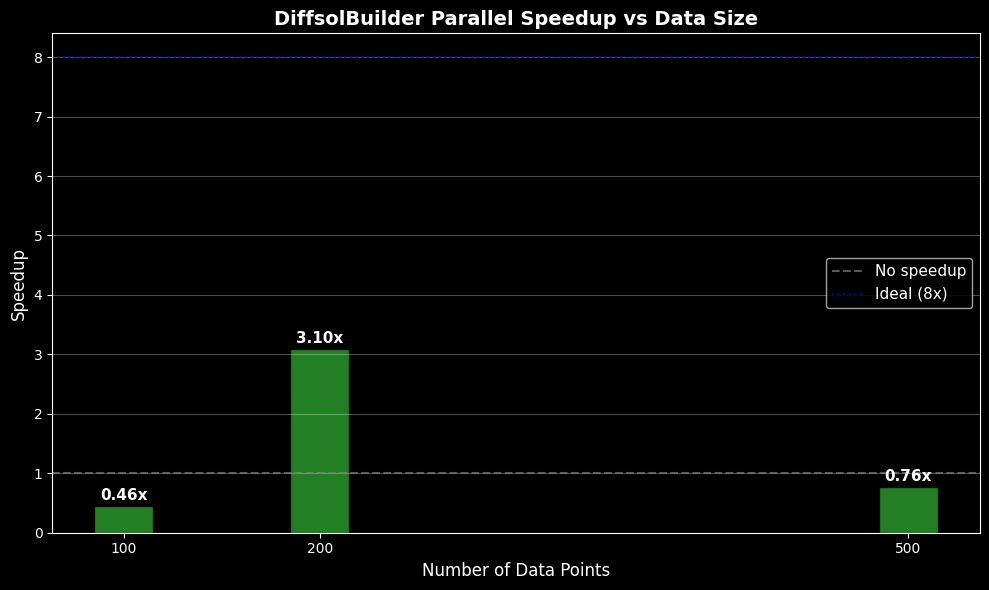


💡 DiffsolBuilder speedup is modest due to efficient solver caching.
   For more parallelism, use multiprocessing with Python callables.


In [9]:
# Visualize DiffsolBuilder scaling
fig, ax = plt.subplots(figsize=(10, 6))

n_pts = [r["n_points"] for r in scaling_results]
speedups_scale = [r["speedup"] for r in scaling_results]

ax.bar(n_pts, speedups_scale, color="#2ca02c", alpha=0.8, edgecolor="black", width=30)
ax.axhline(y=1.0, color="gray", linestyle="--", alpha=0.7, label="No speedup")
ax.axhline(
    y=n_cores, color="blue", linestyle=":", alpha=0.7, label=f"Ideal ({n_cores}x)"
)

ax.set_xlabel("Number of Data Points", fontsize=12)
ax.set_ylabel("Speedup", fontsize=12)
ax.set_title(
    "DiffsolBuilder Parallel Speedup vs Data Size", fontsize=14, fontweight="bold"
)
ax.set_xticks(n_pts)
ax.grid(True, axis="y", alpha=0.3)
ax.legend(fontsize=11)

for x, y in zip(n_pts, speedups_scale, strict=False):
    ax.text(x, y + 0.1, f"{y:.2f}x", ha="center", fontsize=11, fontweight="bold")

plt.tight_layout()
plt.show()

print("\n💡 DiffsolBuilder speedup is modest due to efficient solver caching.")
print("   For more parallelism, use multiprocessing with Python callables.")

## When to Use Each Approach

### DiffsolBuilder with `.with_parallel(True)`

Best for:
- ODE fitting problems where evaluations are moderately expensive
- When you want automatic parallelism without code changes
- Lower overhead than multiprocessing

```python
problem = (
    diffid.DiffsolBuilder()
    .with_diffsl(model)
    .with_data(data)
    .with_parallel(True)  # Enable rayon parallelism
    .build()
)
```

### Multiprocessing for Python Callables

Best for:
- Expensive Python simulations (>10ms per evaluation)
- Complex custom objective functions
- When DiffsolBuilder isn't applicable

```python
from concurrent.futures import ProcessPoolExecutor

def evaluate_parallel(params_list):
    with ProcessPoolExecutor(max_workers=n_cores) as executor:
        return list(executor.map(expensive_objective, params_list))
```

## Best Practices Summary

| Scenario | Recommended Approach | Expected Speedup |
|----------|---------------------|------------------|
| DiffsolBuilder ODE fitting | `.with_parallel(True)` | 1-2x (limited by caching) |
| Expensive Python callable | `multiprocessing` | Near-linear with cores |
| Fast Python callable (<1ms) | Sequential | N/A (overhead dominates) |
| I/O-bound operations | `threading` | Varies |

### Tips for Maximum Speedup

1. **Profile first**: Measure single evaluation time to assess parallel benefit
2. **Use multiprocessing for Python**: Bypass the GIL for CPU-bound work
3. **Match workers to cores**: `n_workers = multiprocessing.cpu_count()`
4. **Batch evaluations**: Amortise process creation overhead
5. **Avoid shared state**: Ensure objective functions are stateless

## Performance Summary

In [10]:
# Final summary
print("=" * 70)
print("PERFORMANCE SUMMARY")
print("=" * 70)

print("\n📊 DiffsolBuilder (rayon parallelism):")
print(f"   Sequential:     {time_seq:.2f}s")
print(f"   Parallel:       {time_par:.2f}s  ({time_seq / time_par:.2f}x speedup)")
print("   Note: Limited speedup due to efficient solver caching")

print("\n📊 Python Callables:")
print(
    f"   Sequential ({n_evals} evals): {time_seq_python:.2f}s ({time_seq_python / n_evals * 1000:.1f}ms/eval)"
)
print("   For parallelism, use multiprocessing in scripts")

print(f"\n🔧 System: {n_cores} CPU cores")

PERFORMANCE SUMMARY

📊 DiffsolBuilder (rayon parallelism):
   Sequential:     0.98s
   Parallel:       0.14s  (6.90x speedup)
   Note: Limited speedup due to efficient solver caching

📊 Python Callables:
   Sequential (20 evals): 0.20s (9.8ms/eval)
   For parallelism, use multiprocessing in scripts

🔧 System: 8 CPU cores


## Key Takeaways

1. **DiffsolBuilder** supports parallel evaluation with `.with_parallel(True)`, but speedup is limited by efficient solver caching

2. **Python callables** can achieve excellent parallelism using `multiprocessing.ProcessPoolExecutor`

3. **Threading doesn't work** for CPU-bound Python code due to the GIL

4. **Profile first** - measure single evaluation time to determine if parallelism will help

5. **Multiprocessing is best** for expensive Python simulations (>10ms per evaluation)

## Next Steps

- [Advanced Cost Functions](advanced_cost_functions.ipynb) - Custom objective functions
- [API Reference: DiffsolBuilder](../../api-reference/python/builders.md#diffsolbuilder) - Complete API
- [API Reference: CMA-ES](../../api-reference/python/optimisers.md#cmaes) - Population configuration

## Exercises

1. **Multiprocessing Integration**: Modify the `expensive_objective` function to use a different ODE system and measure the parallel speedup

2. **Process Pool Reuse**: Create a persistent `ProcessPoolExecutor` and measure the overhead reduction from reusing it across multiple batches

3. **Hybrid Approach**: Combine DiffsolBuilder's parallel evaluation with multiprocessing by running multiple independent optimisation problems in parallel

4. **Scaling Study**: Measure how multiprocessing speedup changes with:
   - Number of workers (1, 2, 4, 8, ...)
   - Evaluation cost (1ms, 10ms, 100ms, 1s)
   - Batch size (10, 50, 100, 500)